<center>
<h1> TP-Projet d'optimisation numérique </h1>
<h1> Algorithme des Régions de Confiance </h1>
</center>

# Régions de confiance avec Pas de Cauchy 

## Implémentation 

1. Coder l'algorithme du pas de Cauchy d’un sous-problème de
régions de confiance (fichier `Pas_De_Cauchy.jl`). La spécification de cet algorithme est donnée ci-dessous.

In [9]:
using LinearAlgebra
using Documenter
using Markdown  
include("Pas_De_Cauchy.jl")
# @doc Pas_De_Cauchy

Pas_De_Cauchy

2. Ecrire des tests exhaustifs (qui testent tous les cas de figure possibles) pour votre algorithme du Pas de Cauchy. Vous créerez pour cela un fichier `tester_pas_de_Cauchy.jl` dans le répertoire `test` sur le modèle des autres fichiers de tests et vous exécuterez dans la cellule de code ci-après ces tests.

3. Coder l'algorithme des Régions de Confiance (fichier `Regions_De_Confiance.jl`). Sa spécification est donnée ci-dessous.

In [10]:
using Test
include("Regions_De_Confiance.jl")
# @doc Regions_De_Confiance
include("../test/tester_pas_de_cauchy.jl")
include("../src/Pas_De_Cauchy.jl")

affiche = false

@testset "Pas de Cauchy" begin
	tester_pas_de_cauchy(affiche,Pas_De_Cauchy)
end;

Test Summary: | Pass  Total  Time
Pas de Cauchy |    7      7  0.3s


4. Vérifier que les tests ci-dessous passent.

In [11]:
using Test

# Tolérance pour les tests d'égalité
tol_erreur = sqrt(eps())

## ajouter les fonctions de test
include("../test/fonctions_de_tests.jl")
include("../test/tester_regions_de_confiance.jl")
include("../src/Pas_De_Cauchy.jl")
include("../src/Gradient_conjugue.jl")
include("../src/Gradient_Conjugue_Tronque.jl")
include("../src/Regions_De_Confiance.jl")

affiche = false

@testset "Test rc avec cauchy" begin
	tester_regions_de_confiance(affiche,Regions_De_Confiance)
end;

iters = 864
Test Summary:       | Pass  Total  Time
Test rc avec cauchy |   30     30  2.3s


In [12]:
#using Pkg; Pkg.add("LinearAlgebra"); Pkg.add("Markdown")
# using Documenter
using LinearAlgebra
using Markdown                             # Pour que les docstrings en début des fonctions ne posent
                                           # pas de soucis. Ces docstrings sont utiles pour générer 
                                           # la documentation sous GitHub
include("Algorithme_De_Newton.jl")

# Affichage les sorties de l'algorithme des Régions de confiance
function my_afficher_resultats(algo,nom_fct,point_init,xmin,fxmin,flag,sol_exacte,nbiters)
	println("-------------------------------------------------------------------------")
	printstyled("Résultats de : ",algo, " appliqué à ",nom_fct, " au point initial ", point_init, ":\n",bold=true,color=:blue)
	println("  * xsol = ",xmin)
	println("  * f(xsol) = ",fxmin)
	println("  * nb_iters = ",nbiters)
	println("  * flag = ",flag)
	println("  * sol_exacte : ", sol_exacte)
end

my_afficher_resultats (generic function with 1 method)

## Interprétation 

<!-- Pour ces questions, des représentations graphiques sont attendues pour corroborer vos réponses. -->

1. Soit $$ f_{1} : \mathbf{R}^3 \rightarrow \mathbf{R}$$ $$ (x_1,x_2, x_3) \mapsto  2 (x_1 +x_2 + x_3 -3)^2 + (x_1-x_2)^2 + (x_2 - x_3)^2$$ Quelle relation lie la fonction $f_1$ et son modèle de Taylor à l’ordre 2 ? Comparer alors les performances de Newton et RC-Pas de Cauchy sur cette fonction.

2.  Le rayon initial de la région de confiance est un paramètre important dans l’analyse
de la performance de l’algorithme. Sur quel(s) autre(s) paramètre(s) peut-on jouer
pour essayer d’améliorer cette performance ? Étudier l’influence d’au moins deux de
ces paramètres. Pour cela vous ferez des tests numériques et donnerez les résultats sous forme de tableaux et de graphiques.

#### Question 1

In [13]:
include("Regions_De_Confiance.jl")

f1(x) = 2*(x[1] + x[2] + x[3] - 3)^2 + (x[1] - x[2])^2 + (x[2] - x[3])^2
grad_f1(x) = [6*x[1] + 2*x[2] + 4*x[3] - 12 ; 2*x[1] + 8*x[2] + 2*x[3] - 12 ; 4*x[1] + 2*x[2] + 6*x[3] - 12]
hess_f1(x) = [[6 2 4] ; [2 8 2] ; [4 2 6]]

sol_exacte = [1 ; 1 ; 1]
x01 = [1 ; 1 ; 0]
xmin,f_min,flag,nb_iters = Regions_De_Confiance("cauchy",f1,grad_f1,hess_f1,x01,[])
my_afficher_resultats("Pas_cauchy","f1",x01,xmin,f_min,flag,sol_exacte,nb_iters)

-------------------------------------------------------------------------
Résultats de : Pas_cauchy appliqué à f1 au point initial [1, 1, 0]:
  * xsol = [1.0000062307077304, 0.9999987514096391, 0.9999912721115476]
  * f(xsol) = 1.3994140189432042e-10
  * nb_iters = 32
  * flag = 2
  * sol_exacte : [1, 1, 1]


La fonction $f_1$ est exactement égale à son développement de Taylor à l’ordre 2. Ainsi Newton trouvera une solution en une itération contrairement aux Régions de Confiance qui converge en 32 itération vers une solution moins précise (e-10 comparé à e-30). L’algorithme des Régions cherche le min selon la direction du gradient courant comparé à Newton qui cherche à minimiser directement.

#### Question 2


On peut jouer sur $\eta_1\ , \eta_2 , \gamma_1 \text{ et }  \gamma_2$. Les critères et facteurs d'agrandissement et de réduction de la région de confiance.

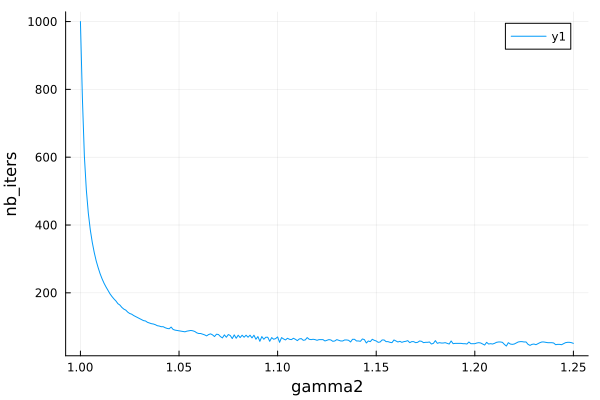

In [17]:
using Plots
l_x = []
l_flag = []
l_f_min = []
l_nb_iter = []
l_gamma2 = []
f2(x) = 100*(x[2] - x[1]^2)^2 + (1 - x[1])^2
grad_f2(x) = [-400*x[1]*(x[2]-x[1]^2) - 2*(1-x[1]) ; 200*(x[2]-x[1]^2) ]
hess_f2(x) = [[(-400*(x[2]-x[1]^2)+800*x[1]^2 +2) (-400*x[1])] ; [-400*x[1] 200] ] 
for i in 1000:1250
    gamma2 = i*0.001
    x_min,f_min,flag,nb_iters = Regions_De_Confiance("cauchy",f1,grad_f1,hess_f1,x01,[100 0.5 gamma2 0.25 0.75 0.001 1000 sqrt(eps()) 1e-15 1.e-2])
    push!(l_x,x_min)
    push!(l_f_min,f_min)
    push!(l_flag,flag)
    push!(l_nb_iter,nb_iters)
    push!(l_gamma2,gamma2) 
end
plot(l_gamma2, l_nb_iter )
xlabel!("gamma2")
ylabel!("nb_iters")




# Régions de confiance avec Gradient Conjugué
## Implémentation 

1. Implémenter l’algorithme du Gradient Conjugué Tronqué (fichier `Gradient_Conjugue_Tronque.jl`). Sa spécification est donnée ci-dessous.

In [23]:
include("Gradient_Conjugue_Tronque.jl")
# @doc Gradient_Conjugue_Tronque

Gradient_Conjugue_Tronque

In [24]:
include("Gradient_conjugue.jl")

Resolution_snd_deg (generic function with 1 method)

2. Vérifier que les tests ci-dessous passent.

In [25]:
using Test

# Tolérance pour les tests d'égalité
tol_erreur = sqrt(eps())

## ajouter les fonctions de test
include("../test/fonctions_de_tests.jl")
include("../test/tester_gct.jl")
include("../src/Gradient_Conjugue_Tronque.jl")

affiche = false

@testset "Test gct" begin
	tester_gct(affiche,Gradient_Conjugue_Tronque)
end;

Test Summary: | Pass  Total  Time
Test gct      |    9      9  1.0s


3. Intégrer l’algorithme du Gradient Conjugué Tronqué dans le code de régions de confiance (fichier `Regions_De_Confiance.jl`).

4. Décommenter les tests avec le gradient conjugué dans `tester_regions_de_confiance.jl` et vérifier que les tests passent.

In [18]:
using Test

# Tolérance pour les tests d'égalité
tol_erreur = sqrt(eps())

## ajouter les fonctions de test
include("../test/fonctions_de_tests.jl")
include("../test/tester_regions_de_confiance.jl")
include("../src/Pas_De_Cauchy.jl")
include("../src/Gradient_Conjugue_Tronque.jl")
include("../src/Regions_De_Confiance.jl")

affiche = false

@testset "Test rc avec cauchy et gct" begin
	tester_regions_de_confiance(affiche,Regions_De_Confiance)
end;

iters = 864
Test Summary:              | Pass  Total  Time
Test rc avec cauchy et gct |   30     30  1.2s


## Interprétation  

1. Comparer la décroissance obtenue avec celle du pas de Cauchy, en imposant la sortie
dans l’algorithme au bout d’une itération seulement. Vous donnerez ci-après des résultats numériques. 
    1. Que remarquez vous ?
    2. Comparer la décroissance obtenue avec celle du pas de Cauchy dans le cas général.

3. Quels sont les avantages et inconvénients des deux approches ?

#### Question 1

En utilisant la fontion $f_2$ de la partie 1, avec comme point initial $x_0 = [-9 ; 7 ]$, on obtienr la décroissance suivante :


| GCT | Cauchy |
| :-:| :----: |
| 371805.17 | 371805.17 | 
| 147478.30 |147478.30 |
| 24921.53 | 24921.53 |
| 3265.41 |3265.41 |
| 213.19 |213.19 |
| 2.40 |2.40 |

Ainsi on remarque qu'en imposant la sortie dans l’algorithme gct au bout d’une itération seulement, les deux algorithmes fournissent la même decroissance

Dans le cas général :

| GCT | Cauchy |
| :-:| :----: |
| 371805.17 | 371805.17 | 
| 152846.88 |147478.30 |
| 22649.39 | 24921.53 |
| 368.14 |3265.41 |
| -134.94 |213.19 |
| -3.11 |2.40 |

On remarque que GCT converge légèrement plus rapidement que Cauchy dans le cas général. Mais des velaurs négatives peuvent apparaître.

#### Question 2

Cauchy : 
* Avantage : Pas de valeurs négatives
* Inconveniant : Moins précis et converge lentement

GCT :
 * Avantage : Converge rapidement vers le minimum
 * Inconveniant : Une plus grande compléxité